In [1]:
# Libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# client location
client = bigquery.Client(location = "europe-north1")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: gentle-pier-291608


In [2]:
# functions

# create de baseline model
def baseline(row):
    # predict failure (1), if any of the SMART is above zero
    if row['smart_5_raw'] > 0 or row['smart_187_raw'] > 0 or row['smart_188_raw'] > 0 or row['smart_197_raw'] > 0 or row['smart_198_raw'] > 0:
        val = 1
    else:
        val = 0
    return val

# evaluation metrics
def evaluation(y_true, y_pred):
    d = {}
    d["accuracy"] = accuracy_score(y_true, y_pred)
    print("accuraccy", round(accuracy_score(y_true, y_pred), 3) )
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    d["tn"] = tn
    d["fp"] = fp
    d["fn"] = fn
    d["tp"] = tp
    d["TPR"] = tp/(tp+fn)
    print("TPR", round(tp/(tp+fn),3))
    d["TNR"] = tn/(tn+fp)
    print("TNR", round(tn/(tn+fp),3))
    d["AUC"] = metrics.roc_auc_score(y_true, y_pred)
    print("AUC", round(metrics.roc_auc_score(y_true, y_pred),3))

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = ["no failure", "failure"], columns = ["no failure", "failure"])
    plt.figure(figsize = (5,3.5))
    sns.set(font_scale = 1.1)
    plt.title('Confusion matrix')
    sns.heatmap(df_cm, annot=True, fmt="d", linewidths=.5)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return d

def basic_RF(N):
    print("Time window:", N)
   
    # baseline model
    print("Baseline model")
    query = """
    SELECT failure, smart_5_raw, smart_187_raw, smart_188_raw, smart_197_raw, smart_198_raw
    FROM df.M1N"""+str(N)+"""D
    """
    query_job = client.query(query, location= "europe-north1")  # API request - starts the query
    blm = query_job.to_dataframe()
    y_true = blm["failure"].values 
    blm['y_pred'] = blm.apply(baseline, axis=1)
    y_pred = blm["y_pred"].values
    evaluation_baseline =  evaluation(y_true, y_pred)
    
    # RF
    print("Random Forest")
    query = """
    SELECT * EXCEPT(random)
    FROM df.M1N"""+str(N)+"""D
    """
    query_job = client.query(query, location= "europe-north1")  # API request - starts the query
    n = query_job.to_dataframe()
    y = n["failure"]
    x_columns = set(n.columns) - set(["failure"])
    X = n[x_columns]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    # train
    RFclf = RandomForestClassifier(random_state = 33)
    RFclf.fit(X_train, y_train)
    # predict
    y_pred = RFclf.predict(X_test)
    evaluation_RF =  evaluation(y_test, y_pred)
    probs = RFclf.predict_proba(X_test)
    
    # feature importance
    feat_importances = pd.Series(RFclf.feature_importances_, index = X_train.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title("Top 10 features N = "+str(N))
    plt.xlabel("feature importance")
    plt.show()
    return evaluation_baseline, evaluation_RF, RFclf.feature_importances_, X_train.columns, RFclf, y_pred, probs

Time window: 1
Baseline model
accuraccy 0.804
TPR 0.677
TNR 0.93
AUC 0.804


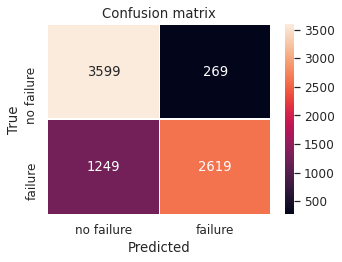

Random Forest
accuraccy 0.832
TPR 0.719
TNR 0.949
AUC 0.834


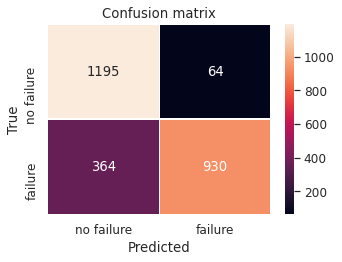

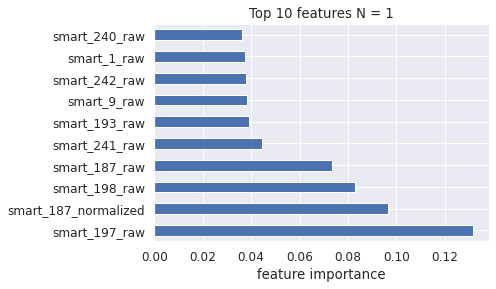

In [3]:
BL_1, RF_1, I_1, cols, clf1, y_pred1, probs1 = basic_RF(N = 1)

Time window: 5
Baseline model
accuraccy 0.751
TPR 0.57
TNR 0.932
AUC 0.751


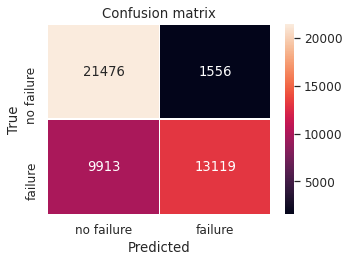

Random Forest
accuraccy 0.951
TPR 0.944
TNR 0.958
AUC 0.951


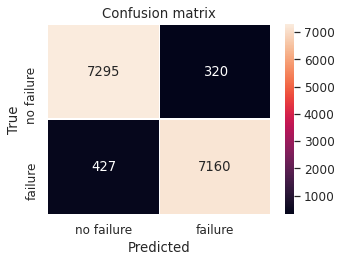

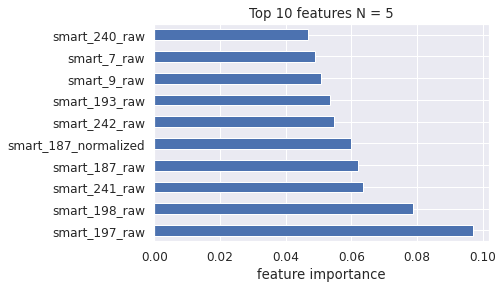

In [4]:
BL_5, RF_5, I_5, cols, clf5, y_pred5, probs5 = basic_RF(N = 5)

Time window: 10
Baseline model
accuraccy 0.73
TPR 0.529
TNR 0.932
AUC 0.73


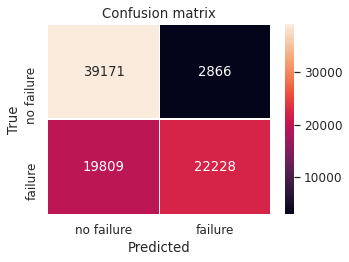

Random Forest
accuraccy 0.974
TPR 0.981
TNR 0.966
AUC 0.974


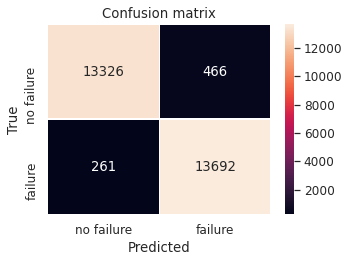

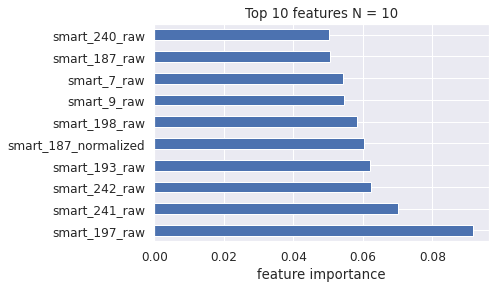

In [5]:
BL_10, RF_10, I_10, cols, clf10, y_pred10, probs10  = basic_RF(N = 10)

In [ ]:
BL_15, RF_15, I_15, col, clf15, y_pred15, probs15 = basic_RF(N = 15)

Time window: 15
Baseline model


In [ ]:
# data
N = [1, 5, 10, 15]

BL_accuracy = [BL_1["accuracy"], BL_5["accuracy"], BL_10["accuracy"], BL_15["accuracy"]]
RF_accuracy = [RF_1["accuracy"], RF_5["accuracy"], RF_10["accuracy"], RF_15["accuracy"]]

BL_TPR = [BL_1["TPR"], BL_5["TPR"], BL_10["TPR"], BL_15["TPR"]]
RF_TPR = [RF_1["TPR"], RF_5["TPR"], RF_10["TPR"], RF_15["TPR"]]

BL_TNR = [BL_1["TNR"], BL_5["TNR"], BL_10["TNR"], BL_15["TNR"]]
RF_TNR = [RF_1["TNR"], RF_5["TNR"], RF_10["TNR"], RF_15["TNR"]]

# plot
fig = plt.figure(figsize= [12,8])
plt.plot(N, BL_accuracy, '--o', label = "BL accuracy", color = "r")
plt.plot(N, RF_accuracy, '-o', label = "RF accuracy", color = "r")

plt.plot(N, BL_TPR, '--o', label = "BL TPR", color = "b")
plt.plot(N, RF_TPR, '-o', label = "RF TPR", color = "b")

plt.plot(N, BL_TNR, '--o', label = "BL TNR", color = "g")
plt.plot(N, RF_TNR, '-o', label = "RF TNR", color = "g")

#plt.ylim(0, 1) 
plt.xticks(np.arange(0, 16, step=5))
plt.xlabel('N')
plt.title('Evaluation metrics by window length')
plt.legend()
plt.show()
fig.savefig('fo.png', bbox_inches='tight')

In [ ]:
y_pred5

In [ ]:
n = 14
m = 8
fig, axes = plt.subplots(nrows=2, ncols=2)

feat_importances = pd.Series(I_1, index = cols)
feat_importances.nlargest(10).plot(ax=axes[0, 0], kind='barh', figsize = (n,m), title = "Top 10 features N = 1")

feat_importances = pd.Series(I_5, index = cols)
feat_importances.nlargest(10).plot(ax=axes[0, 1], kind='barh', color = "g", figsize = (n,m), title = "Top 10 features N = 5")

feat_importances = pd.Series(I_10, index = cols)
feat_importances.nlargest(10).plot(ax=axes[1, 0], kind='barh', color = "r", figsize =(n,m), title = "Top 10 features N = 10")

feat_importances = pd.Series(I_15, index = cols)
feat_importances.nlargest(10).plot(ax=axes[1, 1], kind='barh', color = "k", figsize = (n,m), title = "Top 10 features N = 15")

plt.tight_layout()
fig.savefig('feature_imp.png', bbox_inches='tight')